## Variational Inference in Pyro on CIFAR 10

In [3]:
#Paths
path_to_hw2 = ""
cifar_path = "cifar-10-batches-py"

#### Google Drive Setup

Ensure that `path_to_hw2` is the correct path to your working directory. It should contain a subdirectory that holds the decompressed files from the CIFAR 10 dataset

In [4]:
#Drive Setup (cuda)

import torch
# assert(torch.cuda.is_available())
device = "cuda"

from google.colab import drive
drive.mount('/content/drive')

import os
path_to_batches = path_to_hw2 + "/" + cifar_path
batches = [file for file in sorted(os.listdir(path_to_batches)) if "batch" in file]
batches

Mounted at /content/drive


['batches.meta',
 'data_batch_1',
 'data_batch_2',
 'data_batch_3',
 'data_batch_4',
 'data_batch_5',
 'test_batch']

### Data Pre-Processing

#### Unwrapping CIFAR 10 Python Dataset

CIFAR-10 contains 60K 32x32 images divided into 10 clusters. 
- `test_batch` contains 10K samples.
- `data_batch_{1...5}` contains 10K samples each, amounting to total of 50K samples.
- `batches.meta` contains information on the datasets

In [5]:
import pickle
import os
import numpy

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

data_batches = list()
for i, batch in enumerate(batches):
    batch_path = os.path.join(path_to_batches, batch)
    data_batches.append(unpickle(batch_path))

    print(batch)
    print(data_batches[i].keys())

meta_data = data_batches[0]
training_data = data_batches[1:-1]
test_data = data_batches[-1]

batches.meta
dict_keys(['num_cases_per_batch', 'label_names', 'num_vis'])
data_batch_1
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
data_batch_2
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
data_batch_3
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
data_batch_4
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
data_batch_5
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
test_batch
dict_keys(['batch_label', 'labels', 'data', 'filenames'])


#### CIFAR 10 Databatch Breakdown

The data entry per databatch contains a 10000K samples x 3072 array. The 3072 array corresponds to each 32x32 color image (1024) with a row-major ordering of the 3 channels (R, G, B). The mixture proportions are known, which is why we set θ to constant 1/K = 1/10.

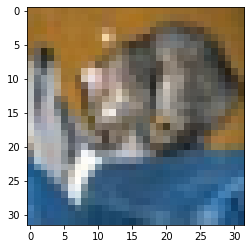

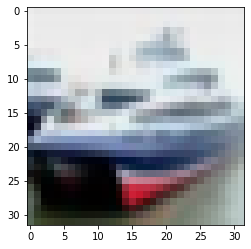

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#reshape image to be column order for output
def reshape(input_img):
  return np.transpose(np.reshape(input_img,(3, 32,32)), (1,2,0))

for single_img in test_data['data'][:2]:
  plt.figure()
  plt.imshow(reshape(single_img))

There are 10 labels shown below that correspond to each image. Hence, we use a mixed model to represent the clustering task since only one image can belong to one label. 

In [7]:
num_cases_per_batch = meta_data['num_cases_per_batch']
num_vis = meta_data['num_vis']
label_names = meta_data['label_names']
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

We perform Principle Component Analysis to reduce the dimensions of the image, hence making variational inference much faster.

In [8]:
from sklearn.decomposition import PCA

pca = PCA(300)

image_train = np.ndarray((len(training_data)*num_cases_per_batch, num_vis)) #combine all batches
for i in range(len(training_data)):
  train_batch = training_data[i]['data']
  image_train[i*num_cases_per_batch:(i+1)*num_cases_per_batch] = train_batch

image_train = pca.fit_transform(image_train)
image_test = pca.transform(test_data['data'])

print("train dim: {}, test dim: {}".format(image_train.shape, image_test.shape))

train dim: (50000, 300), test dim: (10000, 300)


#### Building 10-Cluster Mixed Model for Pyro VI

Installing pyro and building mixed model to perform variational inference

In [9]:
!pip install pyro-ppl

import pyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 722 kB 5.0 MB/s 


In [10]:
#import all necessary packages
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

assert pyro.__version__.startswith('1.8.2')
pyro.set_rng_seed(0)

In [11]:
#num_components
k = 10

def model(data):
    """
    Build Multivariate Gaussian Mixture Model

    <HYPERPARMETERS>
    alpha: Dirichlet concentration for mixture proportions
    eta: variance of each mixture component
    k: number of clusters/components
    image_dim: dimension of vector representation (3072)

    <MODEL>
    theta: mixture proportions defined by Dirichlet(alpha)
    beta: mixture components with parameters defined by Multivariate Normal
    z: latent cluster assignment defined by Categorical(theta)
    observations: sample from assigned component
   

    reference: https://docs.pyro.ai/en/dev/infer.autoguide.html#autodelta
    """

    # define the hyperparameters
    alpha = torch.tensor(0.5) 
    eta = pyro.sample('eta', LogNormal(0., 2.))
    n = torch.tensor(len(data)) 
    image_dim = data.shape[1]

    #mixture proportions
    theta = torch.ones(k)/k

    #mixture components (multivariate Gaussians)
    with pyro.plate("components", k):
      #identity for correlation matrix to depict independent components
      beta = pyro.sample("beta", MultivariateNormal(torch.zeros(image_dim), eta*torch.eye(image_dim)))

    #cluster assignments and data
    with pyro.plate("data", n):
      z = pyro.sample("cluster_assignments", Categorical(theta))
      pyro.sample("obs", MultivariateNormal(beta[z], torch.eye(image_dim)), obs=data)


In [12]:
#build auto guide (variational distribution)
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro import poutine

# def init_loc_fn(site):
#     if site["name"] == "theta":
#         return torch.ones(k) / k #uniform weights
#     elif site["name"] == "eta":
#         return (data.var() / 2).sqrt()
#     elif site["name"] == "beta":
#         return data[torch.multinomial(len(data)) / len(data), k)]
#     raise ValueError(site["name"])

auto_guide = AutoDiagonalNormal(poutine.block(model, expose=['beta', 'eta']))
        # ,init_loc_fn=init_loc_fn)

torch.Size([10000, 300])
iteration 0


/usr/local/lib/python3.7/dist-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'cluster_assignments'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


60147288794.62119
iteration 1
60147292630.36722
iteration 2
60147334050.32915
iteration 3
60147325400.24108
iteration 4
60147280627.165665
iteration 5
60147317255.36081
iteration 6
60147202380.87179
iteration 7
60147272206.37338
iteration 8
60147317330.29349
iteration 9
60147231305.69804
iteration 10
60147198244.79029
iteration 11
60147247769.12966
iteration 12
60147223063.82614
iteration 13
60147194469.10026
iteration 14
60147198186.55713
iteration 15
60147116737.0584
iteration 16
60147128593.85714
iteration 17
60147272256.864296
iteration 18
60147149056.05132
iteration 19
60147124672.72717
iteration 20
60147218912.5894
iteration 21
60147091950.42247
iteration 22
60147128579.42468
iteration 23
60147083599.90712
iteration 24
60147071207.77557
iteration 25
60147132564.53804
iteration 26
60147018040.0427
iteration 27
60146997730.81481
iteration 28
60147054765.50739
iteration 29
60147054968.81596
iteration 30
60146977109.998474
iteration 31
60146989394.90218
iteration 32
60147026154.14884

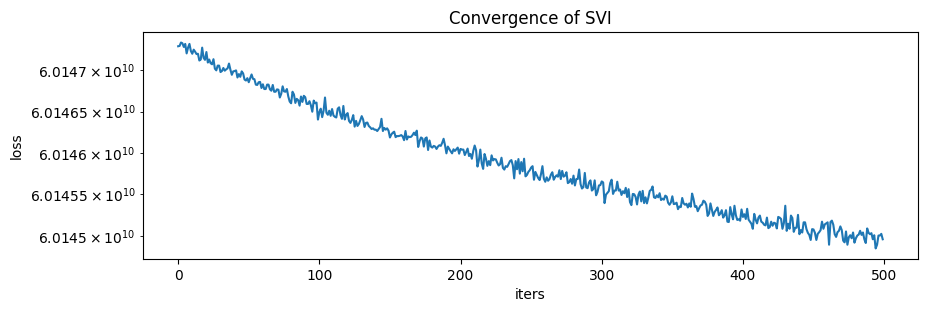

In [13]:
#perform stochastic variational inference
from numpy.random import randint

adam_lr = 0.01
num_iters = 500

# set up the optimizer
adam_params = {"lr": adam_lr}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, auto_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

batch_size = 10000
svi_data = torch.from_numpy(image_train[0:batch_size,])
print(svi_data.shape)

losses = []
# do gradient steps
for step in range(num_iters):
    print("iteration {}".format(step))
    loss = svi.step(svi_data)
    print(loss)
    losses.append(loss)
  
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');
